In [1]:
from preamble import *
from preamble import visits, systeminfo

In [2]:
def convolve_spectrum(model_wavelength, model_flux,sigma=0.0012*u.angstrom):
    """
    Convolve the high-res spectrum with a Gaussian kernel with 
    stddev `sigma`. Then interpolate the result onto the wavelength
    grid of the observations.
    """
    kernel = jnp.exp(
        -0.5 * (model_wavelength - jnp.mean(model_wavelength))**2 / 
        sigma**2
    )
    # don't forget to normalize the kernel!
    kernel = kernel / jnp.sum(kernel)
    
    convolved_model_flux = fftconvolve(
        model_flux, kernel)
    
    # interp_model = jnp.interp(
    #     observed_wavelength, 
    #     model_wavelength, 
    #     convolved_model_flux
    # )
    return convolved_model_flux

In [3]:
def phoenix_spec2T(parameters, w):

    f_cool, T_cool, T_amb = parameters

    filter_response = visits[f'{visit}']['filter_response']
    filter_sigma = visits[f'{visit}']['filter_sigma']
    resampled_filter_response = bintogrid(filter_response.wave.value[0], filter_response.throughput[0], newx = w.value)

    S_cool = get_phoenix_photons(wavelength = w, temperature = T_cool, metallicity = 0.12, logg= 4.52)[1]
    S_amb = get_phoenix_photons(wavelength = w, temperature = T_amb, metallicity = 0.12, logg= 4.52)[1]
    
    model_flux = (f_cool * S_cool + (1.0-f_cool) * S_amb)
    
    observed_model_flux = model_flux * resampled_filter_response['y']

    convolved_model_flux = convolve_spectrum(w, observed_model_flux, sigma=filter_sigma)
    
    return convolved_model_flux

In [4]:
def phoenix_spec3T(parameters, w):

    f_cool, f_hot, T_cool, T_amb, T_hot = parameters

    filter_response = visits[f'{visit}']['filter_response']
    resampled_filter_response = bintogrid(filter_response.wave.value[0], filter_response.throughput[0], newx = w.value)

    f_amb = 1.0 - (f_cool + f_hot)

    S_cool = get_phoenix_photons(wavelength = w, temperature = T_cool, metallicity = 0.12, logg= 4.52)[1]
    S_amb = get_phoenix_photons(wavelength = w, temperature = T_amb, metallicity = 0.12, logg= 4.52)[1]
    S_hot = get_phoenix_photons(wavelength = w, temperature = T_hot, metallicity = 0.12, logg= 4.52)[1]
    
    model_flux = (f_cool*S_cool + f_amb*S_amb + f_hot*S_hot)

    observed_model_flux = model_flux * resampled_filter_response['y']

    convolved_model_flux = convolve_spectrum(w, observed_model_flux, sigma=filter_sigma)

    return convolved_model_flux

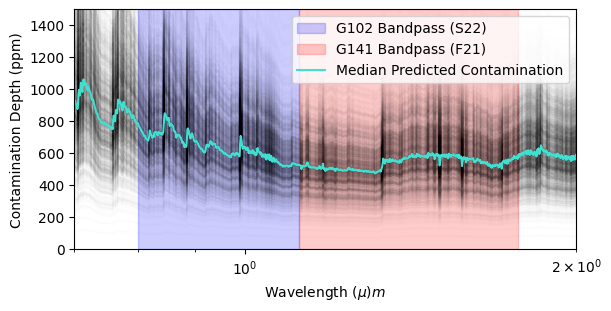

<Figure size 640x480 with 0 Axes>

In [5]:
w = np.geomspace(0.7, 2.0, 1000)*u.micron
# f_cool=0.35
# f_chord=0.0
# T_cool=3100
# T_amb=4000
# transit_depth= 0.0433**2
# parameters = [f_cool, f_chord, T_cool, T_amb, transit_depth]
# delta_D_spot = calculate_delta_D_spot(parameters, w)

transit_depth= 0.0433**2

plt.figure(figsize=(6,3))
plt.xlabel(r'Wavelength $(\mu)m$')
plt.ylabel('Contamination Depth (ppm)')
plt.axvspan(0.8,1.12,zorder=-100,label='G102 Bandpass (S22)',color='blue',alpha=0.2)
plt.axvspan(1.12,1.77,zorder=-100,label='G141 Bandpass (F21)',color='red',alpha=0.2)
plt.xlim(w.value[0],w.value[-1])
plt.ylim(0,1500)
plt.xscale('log')
# plt.title('f_chord = f_cool')
# plt.yscale('log')

sampled_depths = [None]*1000
for j in range(0,1000):
    
    f_cool=np.random.normal(0.39,0.09)
    # f_chord=np.abs(np.random.normal(0.1,0.1))
    f_chord=0
    T_cool=np.random.normal(3050,100)
    T_amb=np.random.normal(4000,50)
    
    parameters = [f_cool, f_chord, T_cool, T_amb, transit_depth]
    delta_D_spot = calculate_delta_D_spot(parameters, w)
    sampled_depths[j] = delta_D_spot
    plt.plot(w,delta_D_spot,color='k',alpha=0.01)

    if j == 999:
        plt.plot(w,np.nanmedian(sampled_depths,axis=0),color='turquoise',alpha=1,label='Median Predicted Contamination')

plt.legend()
plt.savefig('../figs/projected_contamination.png')
plt.show()
plt.clf()